## Preprocess data

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import json_normalize
import json
from collections import Counter

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dense,Flatten, SpatialDropout1D, concatenate
from tensorflow.keras.layers import GRU,Reshape,TimeDistributed,Bidirectional,Dropout,Masking,Conv1D, Conv2D,MaxPool2D,GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.python.keras.layers.merge import Dot
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [ ]:
!wget -q http://www.arts.chula.ac.th/ling/wp-content/uploads/TH-Sarabun_Chula1.1.zip -O font.zip
!unzip -qj font.zip TH-Sarabun_Chula1.1/THSarabunChula-Regular.ttf
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('THSarabunChula-Regular.ttf')
mpl.rc('font', family='TH Sarabun Chula')

In [ ]:
# Load data
df_content = pd.read_csv("pantip_scrapping.csv")

In [ ]:
df_content.head()

,topic_id,title,content,tags
0,40643404,ทริปเกาะเสม็ด 3 วัน 2 คืน วันที่สองที่ทรายแก้ว...,\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tคืนแรกที่เ...,"[{'name': 'เกาะเสม็ด', 'slug': 'เกาะเสม็ด'}, {..."
1,40643393,… ธูษิฏา เวลเนส รีสอร์ต ชุมพร Tusita Wellnes...,\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t. ธูษิ...,"[{'name': 'บันทึกนักเดินทาง', 'slug': 'บันทึกน..."
2,40643087,พาชม สนามกอล์ฟ ศูนย์สร้างทางลำปาง กรมทางหลวง (...,\n\nใบสนร่วงให้ฟีลแผ่นดินสีทอง สวยไปอีกแบบครับ...,"[{'name': 'กอล์ฟ', 'slug': 'กอล์ฟ'}, {'name': ..."
3,40642333,Copenhagen : Summer days - ฤดูร้อนในโคเปนเฮเกน...,\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tทริปนี้เป็...,"[{'name': 'โคเปนเฮเกน', 'slug': 'โคเปนเฮเกน'},..."
4,40642260,📌 แจกพิกัด 6 ทุ่งดอกไม้หลากสีทั่วญี่ปุ่น ที่ไม...,\nถ้าพูดถึงดอกไม้ของญี่ปุ่นหลายๆคนคงจะนึกถึงดอ...,"[{'name': 'เที่ยวญี่ปุ่น', 'slug': 'เที่ยวญี่ป..."


## Preprocess labels

In [ ]:
tag_count = []
tags_temp = []

i = 0
for index, row in df_content.iterrows():
  tags = json.loads(json.dumps(eval(row['tags'])))
  temp = []
  for tag in tags:
    temp.append(tag['slug'])
    tag_count.append(tag['slug'])
  tags_temp.append(temp)

df_content['tags'] = tags_temp
tag_count = Counter(tag_count)

In [ ]:
n_tags = int(0.05*len(tag_count))
Top_tags = sorted(tag_count.items(), key=lambda item: item[1], reverse=True)[:n_tags]
print(Top_tags)

[('บันทึกนักเดินทาง', 5099), ('เที่ยวไทย', 2957), ('เที่ยวต่างประเทศ', 2443), ('สถานที่ท่องเที่ยวต่างประเทศ', 1676), ('สถานที่ท่องเที่ยวในประเทศ', 1651), ('Backpack', 1435), ('โรงแรมรีสอร์ท', 1201), ('ภาพถ่ายทิวทัศน์', 1106), ('เที่ยวทะเล', 1067), ('เที่ยวญี่ปุ่น', 950), ('เที่ยวภูเขา', 833), ('ท่องเที่ยว', 727), ('สถานที่ท่องเที่ยว', 582), ('นักท่องเที่ยว', 551), ('One_Day_Trip', 535), ('ร้านอาหาร', 501), ('โรงแรมรีสอร์ทไทย', 467), ('ภาพถ่ายจากกล้องโทรศัพท์', 454), ('คาเฟ่_(Cafe)', 452), ('ประเทศญี่ปุ่น', 450), ('เที่ยวเชิงอนุรักษ์', 442), ('ภาพถ่าย', 426), ('สถานที่ท่องเที่ยวกรุงเทพฯ', 407), ('สถานที่ท่องเที่ยวสำหรับครอบครัว', 393), ('Slow_Life', 389), ('เที่ยวยุโรป', 361), ('เดินป่า', 332), ('แผนการเดินทางและท่องเที่ยว', 330), ('จังหวัดเชียงใหม่', 280), ('ร้านกาแฟ', 260), ('สายการบิน', 245), ('การท่องเที่ยวแห่งประเทศไทย', 214), ('โตเกียว', 193), ('พัทยา', 185), ('เที่ยววัด', 180), ('เที่ยวน้ำตก', 179), ('จังหวัดภูเก็ต', 174), ('ที่พัก', 166), ('โฮมสเตย์', 162), ('สถานที่ถ่ายรูป', 15

In [ ]:
idx_to_tag = {}
tag_to_idx = {}
i = 0
for tag in Top_tags:
  if tag[0] not in tag_to_idx:
    tag_to_idx[tag[0]] = i
    i += 1
idx_to_tag = {v: k for k, v in tag_to_idx.items()}

In [ ]:
print(idx_to_tag)

{0: 'บันทึกนักเดินทาง', 1: 'เที่ยวไทย', 2: 'เที่ยวต่างประเทศ', 3: 'สถานที่ท่องเที่ยวต่างประเทศ', 4: 'สถานที่ท่องเที่ยวในประเทศ', 5: 'Backpack', 6: 'โรงแรมรีสอร์ท', 7: 'ภาพถ่ายทิวทัศน์', 8: 'เที่ยวทะเล', 9: 'เที่ยวญี่ปุ่น', 10: 'เที่ยวภูเขา', 11: 'ท่องเที่ยว', 12: 'สถานที่ท่องเที่ยว', 13: 'นักท่องเที่ยว', 14: 'One_Day_Trip', 15: 'ร้านอาหาร', 16: 'โรงแรมรีสอร์ทไทย', 17: 'ภาพถ่ายจากกล้องโทรศัพท์', 18: 'คาเฟ่_(Cafe)', 19: 'ประเทศญี่ปุ่น', 20: 'เที่ยวเชิงอนุรักษ์', 21: 'ภาพถ่าย', 22: 'สถานที่ท่องเที่ยวกรุงเทพฯ', 23: 'สถานที่ท่องเที่ยวสำหรับครอบครัว', 24: 'Slow_Life', 25: 'เที่ยวยุโรป', 26: 'เดินป่า', 27: 'แผนการเดินทางและท่องเที่ยว', 28: 'จังหวัดเชียงใหม่', 29: 'ร้านกาแฟ', 30: 'สายการบิน', 31: 'การท่องเที่ยวแห่งประเทศไทย', 32: 'โตเกียว', 33: 'พัทยา', 34: 'เที่ยววัด', 35: 'เที่ยวน้ำตก', 36: 'จังหวัดภูเก็ต', 37: 'ที่พัก', 38: 'โฮมสเตย์', 39: 'สถานที่ถ่ายรูป', 40: 'อาหาร', 41: 'เที่ยวจีน', 42: 'ภาคเหนือ', 43: 'รถไฟ', 44: 'จังหวัดกาญจนบุรี', 45: 'ดำน้ำ', 46: 'โอซาก้า', 47: 'มอเตอร์ไซค์', 48: 'ป

In [ ]:
tags_temp = []

for index, row in df_content.iterrows():
  
  temp = []
  for tag in row['tags']:
    # print(tag)
    if tag in tag_to_idx:
      temp.append(tag_to_idx[tag])
  tags_temp.append(temp)
  
df_content['idx_tags'] = tags_temp

In [ ]:
df_content.head()

,topic_id,title,content,tags,idx_tags
0,40643404,ทริปเกาะเสม็ด 3 วัน 2 คืน วันที่สองที่ทรายแก้ว...,\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tคืนแรกที่เ...,"[เกาะเสม็ด, เที่ยวทะเล, จังหวัดระยอง, เที่ยวไท...","[8, 1, 16]"
1,40643393,… ธูษิฏา เวลเนส รีสอร์ต ชุมพร Tusita Wellnes...,\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t. ธูษิ...,"[บันทึกนักเดินทาง, โรงแรมรีสอร์ท, จังหวัดชุมพร...","[0, 6, 8, 16]"
2,40643087,พาชม สนามกอล์ฟ ศูนย์สร้างทางลำปาง กรมทางหลวง (...,\n\nใบสนร่วงให้ฟีลแผ่นดินสีทอง สวยไปอีกแบบครับ...,"[กอล์ฟ, กีฬาผู้สูงอายุ, เที่ยวไทย, จังหวัดลำปา...",[1]
3,40642333,Copenhagen : Summer days - ฤดูร้อนในโคเปนเฮเกน...,\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\tทริปนี้เป็...,"[โคเปนเฮเกน, เที่ยวยุโรป, บันทึกนักเดินทาง, ปร...","[25, 0, 3]"
4,40642260,📌 แจกพิกัด 6 ทุ่งดอกไม้หลากสีทั่วญี่ปุ่น ที่ไม...,\nถ้าพูดถึงดอกไม้ของญี่ปุ่นหลายๆคนคงจะนึกถึงดอ...,"[เที่ยวญี่ปุ่น, ฮอกไกโด, โตเกียว, โอซาก้า, สถา...","[9, 61, 32, 46, 3]"


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_content['idx_tags'])

y = multilabel_binarizer.transform(df_content['idx_tags'])

In [ ]:
cut_string = r"[\xa0\|\(\)\[\]\{\}\n\t\r-]*"

test = df_content['content'].iloc[-2]
test = "[test] {test} " + test
test

'[test] {test} \r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t😀เริ่มจากเดือนกันยายนปีที่แล้ว เริ่มวางแผน trip ตะลุย hong kong โดยกำหนดเดินทางเดือน มีนาคม 62 จากนั้นก็ตั้งตารอคอยโปรโมชั่นตั๋วถูก ในที่สุดส้มหล่นค่ะ ได้ตั๋วไป-กลับ ภูเก็ต - ฮองกง จาก www.hxexpress.com ในราคา 3400 รวมค่าธรรมเนียมบัตรเครดิต = 3846 บาท โอแม่จ้าว ถูกมวากก จากราคาปกติประมาณ 6000 บาท (ราคานี้คือลากกระเป๋าขึ้นเครื่องนะค่ะ ถ้าจะ load กระเป๋าจ่ายเพิ่มเที่ยวล่ะ 990 บาทจ้า)\n\n😀เมื่อได้ตั๋วแล้ว step ต่อไปคือการหาที่พัก เราทำการบ้านอย่างหนัก ในการเลือกโรงแรม โดยมี เงื่อนไขการจองโรงแรม 1.งบไม่เกิน 2,500 บาทต่อคืน 2.ขอเป็นโรงแรมไม่เอา guest house เพราะ guest house ห้องเล็กมากกก ไม่มีทางเดินในห้อง เปิดประตูปุ๊บจะเจอปลายเตียงทันที ห้องแบบโรงแรมยังพอมีทางเดินในห้องบ้างพอให้หายใจโล่งๆ 3. ขอโรงแรมใกล้สถานีรถไฟฟ้า เดินไม่เกิน 300 เมตร เพราะขี้เกียจเดินค่ะ 4.ขอโรงแรมที่เป็นจุดจอดของรถรับส่งสนามบิน เพราะขี้เกียจลากกระเป๋าไปขึ้นรถ หุหุ เงื่อนไขเจ้เยอะไปป่าว สุดท้ายมาลงตัวที่ NOBEL PARK HOTEL ย่าน Jodan จองผ่าน www.booking.com ในราคา 2800 บ

In [ ]:
import re
re.sub(cut_string, "", test)

'test test 😀เริ่มจากเดือนกันยายนปีที่แล้ว เริ่มวางแผน trip ตะลุย hong kong โดยกำหนดเดินทางเดือน มีนาคม 62 จากนั้นก็ตั้งตารอคอยโปรโมชั่นตั๋วถูก ในที่สุดส้มหล่นค่ะ ได้ตั๋วไปกลับ ภูเก็ต  ฮองกง จาก www.hxexpress.com ในราคา 3400 รวมค่าธรรมเนียมบัตรเครดิต = 3846 บาท โอแม่จ้าว ถูกมวากก จากราคาปกติประมาณ 6000 บาท ราคานี้คือลากกระเป๋าขึ้นเครื่องนะค่ะ ถ้าจะ load กระเป๋าจ่ายเพิ่มเที่ยวล่ะ 990 บาทจ้า😀เมื่อได้ตั๋วแล้ว step ต่อไปคือการหาที่พัก เราทำการบ้านอย่างหนัก ในการเลือกโรงแรม โดยมี เงื่อนไขการจองโรงแรม 1.งบไม่เกิน 2,500 บาทต่อคืน 2.ขอเป็นโรงแรมไม่เอา guest house เพราะ guest house ห้องเล็กมากกก ไม่มีทางเดินในห้อง เปิดประตูปุ๊บจะเจอปลายเตียงทันที ห้องแบบโรงแรมยังพอมีทางเดินในห้องบ้างพอให้หายใจโล่งๆ 3. ขอโรงแรมใกล้สถานีรถไฟฟ้า เดินไม่เกิน 300 เมตร เพราะขี้เกียจเดินค่ะ 4.ขอโรงแรมที่เป็นจุดจอดของรถรับส่งสนามบิน เพราะขี้เกียจลากกระเป๋าไปขึ้นรถ หุหุ เงื่อนไขเจ้เยอะไปป่าว สุดท้ายมาลงตัวที่ NOBEL PARK HOTEL ย่าน Jodan จองผ่าน www.booking.com ในราคา 2800 บาท/คืน เกิน budget ไปนิดหน่อย ไม่เป็นไร แลกกับเง

In [ ]:
print("Before")
print(df_content['title'].iloc[4])
print("After")
print(re.sub(cut_string, "", df_content['title'].iloc[4]))

Before
📌 แจกพิกัด 6 ทุ่งดอกไม้หลากสีทั่วญี่ปุ่น ที่ไม่ควรพลาด | MeTrip
After
📌 แจกพิกัด 6 ทุ่งดอกไม้หลากสีทั่วญี่ปุ่น ที่ไม่ควรพลาด  MeTrip


In [ ]:
df_content['clean_content'] = df_content['title'] + df_content['content']
df_content['clean_content'] = df_content['clean_content'].apply(lambda x: re.sub(cut_string, "", x))

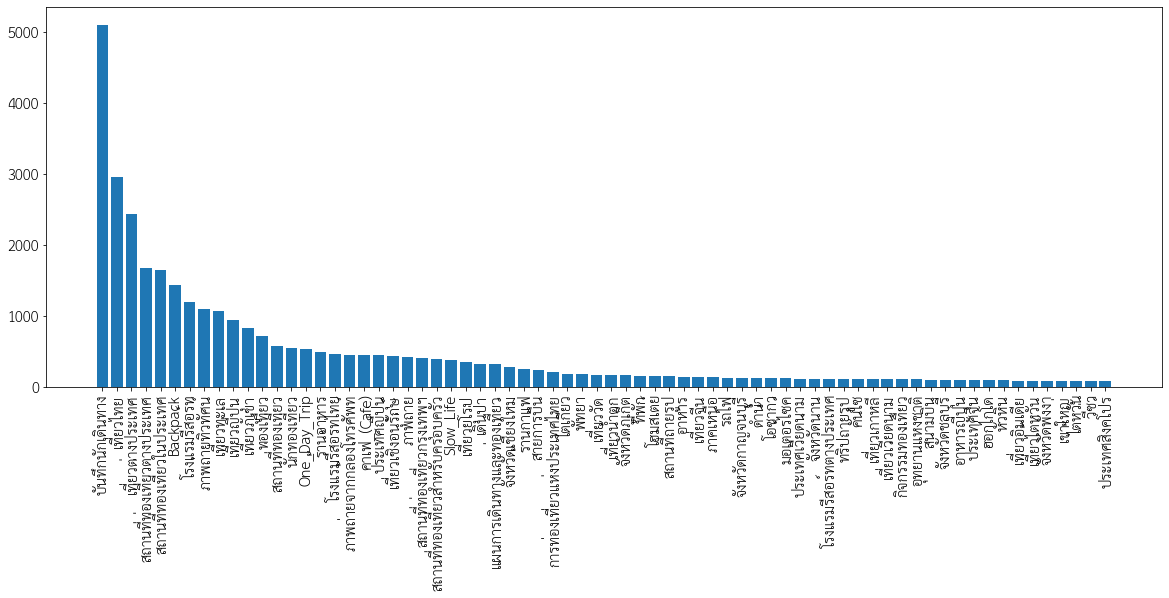

In [ ]:
Tags_ = [i[0] for i in Top_tags]
Count_ = [i[1] for i in Top_tags]

font = {'size': 22}
plt.rc('font', **font)
plt.figure(figsize=(20, 7))
plt.bar(Tags_, Count_)
plt.xticks(rotation=90)
plt.show()

## Tokenizer

In [ ]:
!pip install pythainlp
from pythainlp.tokenize import word_tokenize
from pythainlp.tokenize import syllable_tokenize

In [ ]:
X = df_content['clean_content'].tolist()

In [ ]:
df_content['clean_content'].tolist()[0]

'ทริปเกาะเสม็ด 3 วัน 2 คืน วันที่สองที่ทรายแก้วบีช หาดทรายแก้ว ต่อจากคืนแรกที่ เลอวิมานคืนแรกที่เลอวิมาน อ่าวพร้าว เสม็ดhttps://pantip.com/topic/4063985325 มีค 2021มาต่อกันที่หาดทรายแก้ว ที่นี่มีร้านค้า ร้านอาหารให้บริการพลุกพล่านกว่าที่อ่าวพร้าวมาก รถสองแถวจากเลอวิมาน อ่าวพร้าวพาเราถึงที่พัก หาดทรายแก้วบีชใช้เวลาไม่นานประมาณ 1015 นาทีทรายแก้วบีชเป็นโรงแรมในเครือเดียวกับเลอวิมาน อ่าวพร้าวรีสอร์ทและปารดี ห้องพักที่นี่ใหม่สะดวกสบาย ติดทะเลมีหลายโซนให้เลือกพัก ไลน์อาหารเช้าเยอะและมีบริการรับส่งฟรีไปกลับจากท่าเรืออ่าวพร้าวเช่นกัน ที่ตั้งของรีสอร์ทจะอยู่ท้ายหาดจึงมีความเป็นส่วนตัว เงียบกว่าโซนอื่น จากที่เดินสำรวจที่นี่เป็นรีสอร์ทที่ดีที่สุดในหาดทรายแก้วค่ะ '

In [ ]:
# Tokenize
word_to_idx ={}
idx_to_word ={}

content = df_content['clean_content'].tolist()

new_content = []
for sentence in content:
  text = word_tokenize(sentence, engine="newmm")
  for word in text:
    if word not in word_to_idx:
      word_to_idx[word] = len(word_to_idx) + 1
      idx_to_word[word_to_idx[word]] = word
  new_content.append(text)
word_to_idx['UNK'] = len(word_to_idx)
content_newmm = new_content

del new_content

In [ ]:
vocab_size = len(word_to_idx)

In [ ]:
# content to sequences
content_seq = []
for c in content_newmm:
  temp = []
  for word in c:
    if word in word_to_idx:
      temp.append(word_to_idx[word])
    else:
      temp.append(word_to_idx['UNK'])
  content_seq.append(temp)

In [ ]:
content_lengths = []

for i in content_newmm:
    content_lengths.append(len(i))

In [ ]:
max_length = int(pd.Series(content_lengths).quantile(0.8))

In [ ]:
from keras.preprocessing.sequence import pad_sequences
padded_content = pad_sequences(content_seq, maxlen=max_length, padding='post', truncating='post')

In [ ]:
print(content_newmm[2])
print(content_seq[2])
print(padded_content[2])

['พา', 'ชม', 'สนามกอล์ฟ', 'ศูนย์', 'สร้าง', 'ทาง', 'ลำปาง', 'กรมทางหลวง', ' ', 'ยุค', 'เริ่ม', 'โควิด', 'ระลอก', '3...', 'สนาม', 'ให้', 'บรรยากาศ', 'ลูกทุ่ง', 'แผ่นดิน', 'ทอง', 'ดี', 'ครับ', 'ใบ', 'สน', 'ร่วง', 'ให้', 'ฟี', 'ล', 'แผ่นดิน', 'สี', 'ทอง', ' ', 'สวย', 'ไป', 'อีก', 'แบบ', 'ครับ', 'ช่วง', 'หน้าร้อน', ' ', 'รักษา', 'กรีน', 'ไป', 'ก่อน', 'นะ', 'ครับ', 'พา', 'ไป', 'ชม', ' ', 'สนาม', 'เข', 'ลาง', 'ค์', 'นคร', ' ', 'ของ', ' ', 'ทหารบก', ' ', 'แล้ว', 'บ่าย', 'วันเดียวกัน', 'นั้น', 'ก็', 'ไป', 'ต่อ', 'ที่', ' ', 'สนาม', 'ศูนย์', 'สร้าง', 'ทาง', 'ลำปาง', ' ', 'ของ', ' ', 'กรมทางหลวง', 'ผม', 'เคย', 'สงสัย', 'ว่า', 'มี', 'สนาม', 'ทหาร', ' ', 'สนาม', 'ตำรวจ', ' ', 'สนาม', 'เขื่อน', 'แล้ว', 'เพิ่ง', 'รู้', 'ว่า', 'มี', ' ', 'สนาม', 'กรมทางหลวง', ' ', 'สังกัด', ' ', 'กระทรวงคมนาคม', ' ', 'ก็', 'ครั้งนี้', 'เคย', 'ดู', 'รีวิว', 'สนาม', 'นี้', 'ของ', 'พี่', ' ', 'GumpzZ', ' ', 'เมื่อ', 'หลาย', 'ปีก่อน', 'สนาม', 'นี้', 'ไป', 'ตี', 'มา', 'เมื่อ', ' ', '5', ' ', 'เม.ย.', ' ', '64', ' ', 'โท',

In [ ]:
padded_content.shape, y.shape

((10000, 1288), (10000, 70))